In [22]:
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
import dask

import pandas as pd
import dask.dataframe as dd
import geopandas as gpd
import math
import numpy as np

import momepy
from scripts.tessellation import enclosed_tessellation

In [2]:
Daskcluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(Daskcluster)
client

2023-04-09 00:09:37,129 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 7.56 GiB
2023-04-09 00:09:37,141 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 7.56 GiB
2023-04-09 00:09:37,150 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 7.56 GiB
2023-04-09 00:09:37,159 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 7.56 GiB
2023-04-09 00:09:37,166 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 7.56 GiB
2023-04-09 00:09:37,179 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 7.56 GiB
2023-04-09 00:09:37,187 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 7.56 GiB
2023-04-09 00:09:37,196 - d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 60.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36161,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 60.47 GiB
Comm: tcp://127.0.0.1:39111,Total threads: 2
Dashboard: http://127.0.0.1:43147/status,Memory: 7.56 GiB
Nanny: tcp://127.0.0.1:33613,


In [3]:
streets = gpd.read_parquet("./out/singapore/streets.pq").explode()

buildings = gpd.read_parquet("./out/singapore/buildings.pq")

study_area = gpd.read_parquet("./out/singapore/study_area.pq")

/tmp/ipykernel_25021/343581304.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet("./out/singapore/streets.pq").explode()


In [4]:
## split streets into 64 smaller dataframe
def split(df, n_splits):
    n_features_per_split = math.ceil(len(df) / n_splits)
    splits = []
    for i, df in enumerate(np.array_split(df, n_splits)):
        splits.append(gpd.GeoDataFrame(df, crs=df.crs, geometry='geometry'))
    return splits

streets_list = split(streets, 64)

In [5]:
@delayed
def apply_buffer(df):
    return df.buffer(10)

delay_objs = [apply_buffer(df) for df in streets_list]
results = dask.compute(*delay_objs)

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:96: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  return pickle.loads(x)
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:96: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still us

In [6]:
# merge all the dataframes of results, a list of dataframes, into one dataframe

df = pd.concat(results)
streets_buffer = gpd.GeoDataFrame(df, geometry=df)

In [7]:
study_area = gpd.GeoDataFrame(pd.concat( [study_area, streets_buffer], ignore_index=True)).dissolve()

/home/virgilxw/miniconda3/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as SVY21 / Singapore TM (the single non-null crs provided).
  warnings.warn(


<AxesSubplot: >

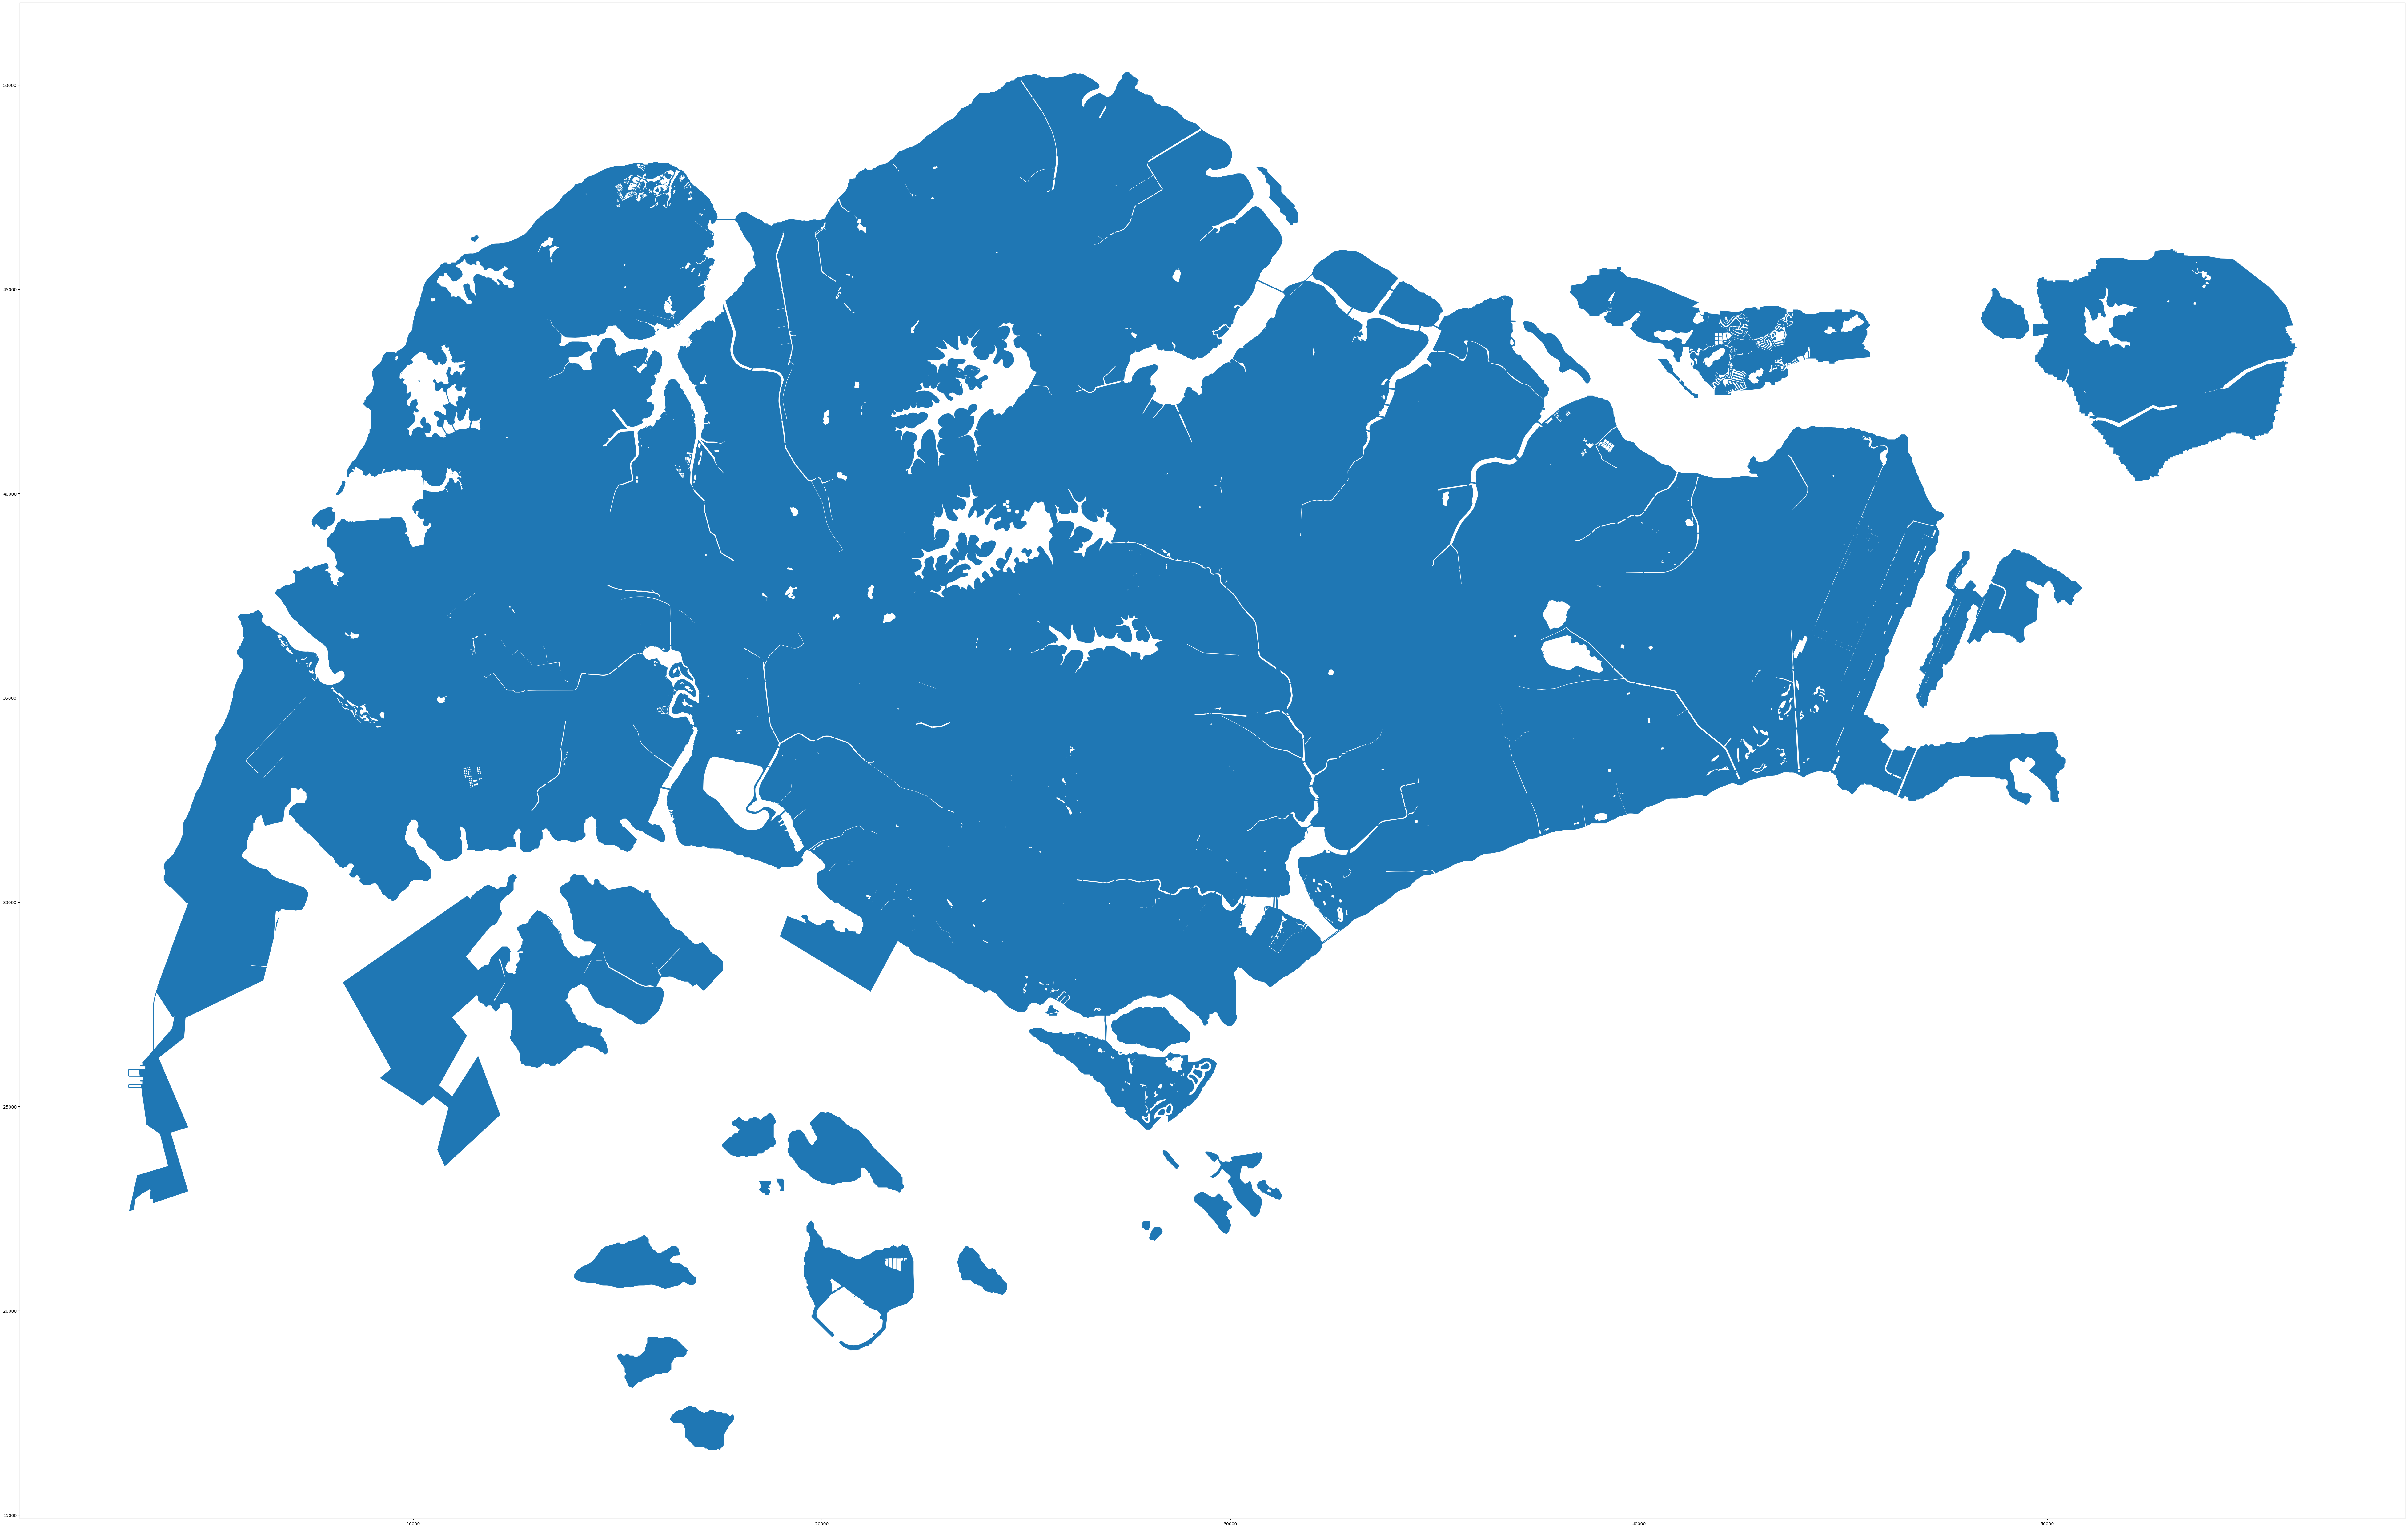

In [8]:
study_area.plot(figsize=(100,100))

In [11]:
enclosures = momepy.enclosures(streets, limit= study_area)

In [19]:
#confirm that no polygons in enclosures overlap another polygon
def overlaps_test(df):
    return df.geometry.overlaps(df.geometry).sum()

print(overlaps_test(enclosures))

0


In [28]:
tessellation = momepy.Tessellation(buildings, unique_id='uID', enclosures=enclosures, use_dask = True).tessellation

# for debugging
tessellation_copy = tessellation

In [ ]:
# Perform a spatial join on the tessellation data
overlapping_polygons = gpd.sjoin(tessellation, tessellation, op='intersects')

# Print any overlapping polygons
if len(overlapping_polygons) > len(tessellation)):
    print("The following polygons in the tessellation overlap:")
    print(overlapping_polygons)
else:
    print("No overlapping polygons found in the tessellation.")

In [ ]:
f, ax = plt.subplots(figsize=(100, 100))
tessellation.plot(ax=ax, edgecolor='black')
buildings.plot(ax=ax, color='white', alpha=.5)
plt.show()